<a href="https://colab.research.google.com/github/apconzuelo/PTSCpy/blob/master/factores_de_riesgo_covid_en_m_xico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
 path = 'gdrive/My Drive/Colab Notebooks/kaggle/CoVID19MX'

In [ ]:
files

input  nbs


In [ ]:
import os
import pandas as pd
import numpy as np

#os.chdir(path)
files =  os.listdir('input')
names = [name.split('.')[0].lower() for name in files]
for name, file in zip(names, files):
    globals()[name] = pd.read_csv('input/' + file)
names
general = globals()['covid-19_general_mx']

In [ ]:
general = general.replace({'SECTOR':sector.to_dict()['DESCRIPCIÓN'],
                'SEXO':{1: 'MUJER', 2:'HOMBRE', 99: 'OTRO'},
                'TIPO_PACIENTE':tipo_paciente.to_dict()['DESCRIPCIÓN'],
                'RESULTADO': {1: True, 2:False, 3:np.nan},
                'NACIONALIDAD':nacionalidad.to_dict()['DESCRIPCIÓN']})

general = general[general['RESULTADO'] == True]
estados = ['ENTIDAD_UM', 'ENTIDAD_RES']
general[estados] = general[estados].sub(1)

In [ ]:
ent_dict = entidades.to_dict()['ENTIDAD_FEDERATIVA']
#estado_totales.reset_index().info()
#estado_totales.reset_index().replace({'ENTIDAD_UM': ent_dict}).head()
ent_dict[8]

'CIUDAD DE MÉXICO'

In [ ]:
general[estados] = general[estados].replace(ent_dict)

In [ ]:
edad = general.EDAD
nacionalidad = general.NACIONALIDAD
for column in general.iloc[:, 9:24].columns.values.tolist():
    general.loc[:, column] = general.loc[:, column].map({1:1, 2:0,
                           97:np.nan, 98:np.nan,
                          99:np.nan})
general.EDAD = edad
general.NACIONALIDAD = nacionalidad.replace({'NO ESPECIFICADO': 'EXTRANJERA', 
                                             'EXTRANJERA': 'MEXICANA'})

In [ ]:
general.NACIONALIDAD.value_counts()

MEXICANA      219792
EXTRANJERA       865
Name: NACIONALIDAD, dtype: int64

In [ ]:
general.loc[:, 'UCI'] = general.loc[:, 'UCI'].map({1: True, 2: False,
                               97:np.nan, 98:np.nan, 99:np.nan})
general['UCI']

0           NaN
1           NaN
2         False
3         False
4         False
          ...  
220652    False
220653      NaN
220654      NaN
220655      NaN
220656    False
Name: UCI, Length: 220657, dtype: object

In [ ]:
general['ESTADO'] = general['FECHA_DEF'].replace({'9999-99-99': np.nan}).isna()
general.ESTADO = general.ESTADO.replace({True:'VIVO', False:'MUERTO'})
general['FECHA_DEF']= general['FECHA_DEF'].replace({'9999-99-99':np.nan})
general.FECHA_INGRESO = pd.to_datetime(general.FECHA_INGRESO)
general.FECHA_SINTOMAS = pd.to_datetime(general.FECHA_SINTOMAS)
general.FECHA_DEF = pd.to_datetime(general.FECHA_DEF)

In [ ]:
general.EDAD.head()

0    27
1    24
2    54
3    30
4    60
Name: EDAD, dtype: int64

In [ ]:
#dummy_general = pd.get_dummies(general, columns =['SEXO', 'TIPO_PACIENTE'])
#dummy_general.head()

In [ ]:
def grupo_edad(x):
    if x <=10:
        grupo = 'INFANTE'
    elif x<=20:
        grupo = 'ADOLESCENTE'
    elif x<=30:
        grupo = 'ADULTO 20s'
    elif x<=40:
        grupo = 'ADULTO 30s'
    elif x<=50:
        grupo = 'ADULTO 40s'
    elif x<=60:
        grupo = 'ADULTO 50s'
    elif x <=70:
        grupo = 'ADULTO 60s'
    else:
        grupo = 'ANCIANO'
    return grupo

general['GRUPO'] = general.EDAD.apply(grupo_edad)

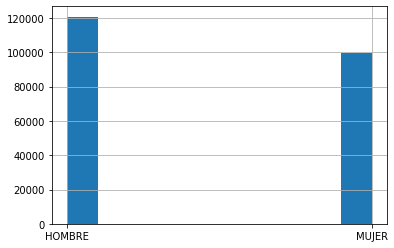

In [ ]:
import matplotlib.pyplot as plt
general['SEXO'].hist()
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


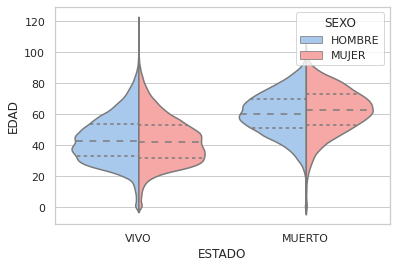

In [ ]:
import seaborn as sns

sns.set(style = 'whitegrid', palette ='pastel', color_codes = True)

ax = sns.violinplot(x = 'ESTADO', y = 'EDAD',
               hue = 'SEXO', split = True,
               inner = 'quart', data = general,
               palette = {'HOMBRE':'b', 'MUJER':'r'},
               saturation = 0.8)
#ax.set(xlabel = 'ESTATUS')

plt.show()




In [ ]:
grupo_edad = general.groupby(['GRUPO', 'ESTADO'])['ESTADO'].count()
total_grupo = general.groupby('GRUPO')['ESTADO'].count()
total_grupo = pd.DataFrame(total_grupo).rename(columns = {'ESTADO':'TOTAL'}).reset_index()
#sobrevivencia = grupo_edad.merge(total_grupo, on = 'GRUPO')

In [ ]:
grupo_edad = pd.DataFrame(grupo_edad).rename(columns = {'ESTADO':'CONTEO'}).reset_index()
superv_grupo = grupo_edad.merge(total_grupo, on ='GRUPO')
superv_grupo['PROPORCIONAL'] = superv_grupo.CONTEO.values/superv_grupo.TOTAL.values

In [ ]:
mortalidad = superv_grupo[superv_grupo['ESTADO'] == 'MUERTO']
supervivencia = superv_grupo[superv_grupo['ESTADO'] == 'VIVO']

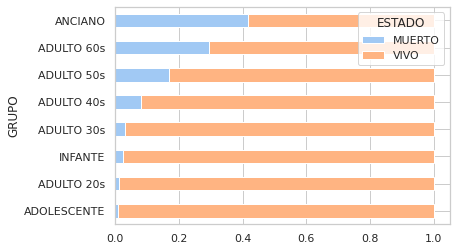

In [ ]:
superv_grupo.set_index(
    ['GRUPO', 'ESTADO']
)['PROPORCIONAL'].unstack().reset_index().sort_values('MUERTO').plot(
x = 'GRUPO', kind = 'barh', stacked = True)
plt.show()

In [ ]:
grupo_sexo = general.groupby(['GRUPO', 'SEXO', 'ESTADO'])['ESTADO'].count().unstack()
grupo_sexo['MORTALIDAD'] = grupo_sexo.MUERTO/(grupo_sexo.MUERTO+grupo_sexo.VIVO)
mortalidad_grupo_sexo = grupo_sexo['MORTALIDAD'].unstack().reset_index().sort_values('HOMBRE')
mortalidad_grupo_sexo.head()

SEXO,GRUPO,HOMBRE,MUJER
0,ADOLESCENTE,0.007429,0.010684
1,ADULTO 20s,0.015466,0.009618
7,INFANTE,0.029257,0.021703
2,ADULTO 30s,0.041278,0.019051
3,ADULTO 40s,0.106118,0.052337


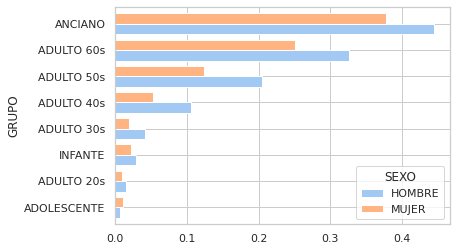

In [ ]:
mortalidad_grupo_sexo.plot(x = 'GRUPO', kind = 'barh',  width = 0.8)
plt.show()

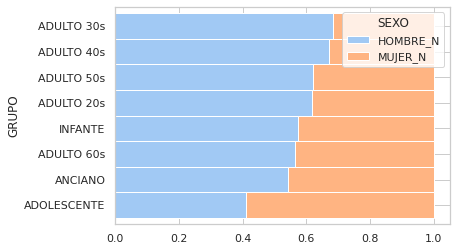

In [ ]:
mortalidad_grupo_sexo.assign(
TOTAL = lambda x: x.HOMBRE + x.MUJER, 
HOMBRE_N = lambda x: x.HOMBRE/x.TOTAL,
MUJER_N = lambda x: x.MUJER/x.TOTAL)[['GRUPO','HOMBRE_N', 'MUJER_N']].sort_values('HOMBRE_N').plot(
    x = 'GRUPO', kind = 'barh', stacked = True, width = 1)
plt.show()

In [ ]:
factores = ['ESTADO', 'GRUPO', 'SEXO', 'DIABETES', 'EPOC', 'ASMA',
              'INMUSUPR', 'CARDIOVASCULAR',
             'OBESIDAD', 'RENAL_CRONICA', 
              'TABAQUISMO', 'OTRA_CON']

factores_df = general[factores]
factores_df.index.name = 'ID'
factores_df = factores_df.replace({np.nan:False})
factores_df = factores_df.assign(
    SANO = lambda x: ~x.iloc[:, 3:12].any(axis = 1))

factores_df['ANTECEDENTES'] = ~factores_df.SANO
factores_df = factores_df.replace({True:1, False:0})
factores_df.head()

,ESTADO,GRUPO,SEXO,DIABETES,EPOC,ASMA,INMUSUPR,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRA_CON,SANO,ANTECEDENTES
ID,,,,,,,,,,,,,,
0,VIVO,ADULTO 20s,HOMBRE,0,0,0,0,0,0,0,0,0,1,0
1,VIVO,ADULTO 20s,HOMBRE,0,0,0,0,0,0,0,0,0,1,0
2,VIVO,ADULTO 50s,MUJER,0,0,0,0,0,1,0,0,0,0,1
3,VIVO,ADULTO 20s,HOMBRE,0,0,0,0,0,0,0,0,0,1,0
4,MUERTO,ADULTO 50s,MUJER,1,0,0,0,1,0,0,0,0,0,1


In [ ]:
def filter_drop(data, column, value):
  df = data[data[column]==value].drop(columns = column)
  return df

In [ ]:
fact_df = factores_df.groupby(['GRUPO', 
                               'ESTADO', 
                               'SEXO']).agg(sum).reset_index()
fact_df.head()

,GRUPO,ESTADO,SEXO,DIABETES,EPOC,ASMA,INMUSUPR,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRA_CON,SANO,ANTECEDENTES
0,ADOLESCENTE,MUERTO,HOMBRE,0,0,0,5,1,3,2,1,3,10,10
1,ADOLESCENTE,MUERTO,MUJER,3,0,0,8,1,6,3,0,5,12,18
2,ADOLESCENTE,VIVO,HOMBRE,30,3,124,39,25,209,19,128,53,2140,532
3,ADOLESCENTE,VIVO,MUJER,33,3,98,36,20,212,22,70,43,2318,460
4,ADULTO 20s,MUERTO,HOMBRE,25,3,11,14,8,82,31,29,21,103,154


In [ ]:
fact_melt = fact_df.melt(id_vars=['GRUPO', 'ESTADO', 'SEXO'],
             var_name='CONDICION', value_name='CASOS')
muertos_melt = filter_drop(fact_melt, 'ESTADO', 'MUERTO')
vivos_melt = filter_drop(fact_melt, 'ESTADO', 'VIVO')

In [ ]:
agrupaciones = ['GRUPO', 'SEXO', 'ESTADO']
sano_yn = ['SANO', 'ANTECEDENTES']
cond_list = list(['DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 
             'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA',
             'TABAQUISMO', 'OTRA_CON'])

In [ ]:
norm_df = fact_df.groupby(['GRUPO', 'SEXO']).sum()
fact_norm =fact_df.set_index(['GRUPO', 'SEXO'])/norm_df
fact_norm = fact_norm.reset_index()
fact_norm['ESTADO'] = ['MUERTO', 'VIVO']*16
fact_norm_melt = fact_norm.melt(id_vars = ['GRUPO', 'SEXO', 'ESTADO'],
                           var_name = 'CONDICION', value_name = 'TASA')


sup_antecedentes = fact_norm_melt[fact_norm_melt['CONDICION'].isin(sano_yn)]
sup_antecedentes = filter_drop(sup_antecedentes, 'ESTADO', 'VIVO')
sup_condiciones = fact_norm_melt[fact_norm_melt['CONDICION'].isin(cond_list)]
sup_condiciones = filter_drop(sup_condiciones, 'ESTADO', 'VIVO')

In [ ]:
sup_condiciones

,GRUPO,SEXO,CONDICION,TASA
33,ADOLESCENTE,HOMBRE,ASMA,1.000000
35,ADOLESCENTE,MUJER,ASMA,1.000000
37,ADULTO 20s,HOMBRE,ASMA,0.975717
39,ADULTO 20s,MUJER,ASMA,0.989565
41,ADULTO 30s,HOMBRE,ASMA,0.960951
...,...,...,...,...
343,ADULTO 60s,MUJER,TABAQUISMO,0.751269
345,ANCIANO,HOMBRE,TABAQUISMO,0.537398
347,ANCIANO,MUJER,TABAQUISMO,0.571930
349,INFANTE,HOMBRE,TABAQUISMO,1.000000


In [ ]:
def mapa_cuadrado(*args, **kwargs):
    data = kwargs.pop('data')
    sortby = kwargs.pop('sortby')
    d = data.pivot(index = args[1], columns = args[0], values = args[2]
                   ).sort_values(sortby, ascending = False)
    sns.heatmap(d*100//1 -1, **kwargs)

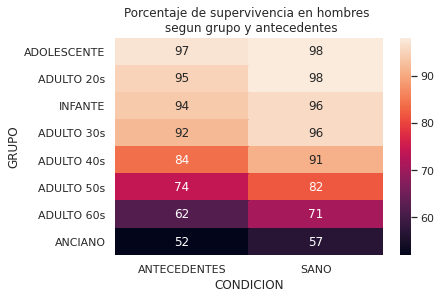

In [ ]:
sexo = 'HOMBRE'
mapa_cuadrado('CONDICION', 'GRUPO', 'TASA',
              data = filter_drop(sup_antecedentes, 'SEXO', 'HOMBRE'), 
              annot = True, sortby ='ANTECEDENTES')
plt.title('Porcentaje de supervivencia en hombres \n segun grupo y antecedentes')
plt.show()

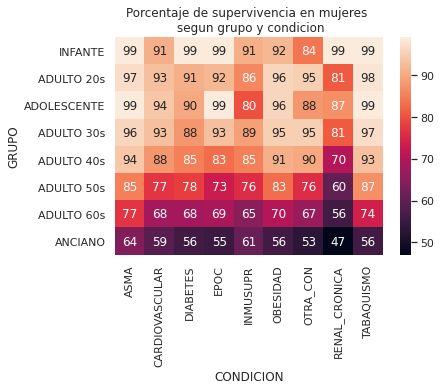

In [ ]:
mapa_cuadrado('CONDICION', 'GRUPO', 'TASA', 
              data = filter_drop(sup_condiciones, 'SEXO', 'MUJER'),
              annot = True, sortby = 'DIABETES')
plt.title('Porcentaje de supervivencia en mujeres \n segun grupo y condicion')
plt.show()

In [ ]:
def corr_heatmap(df, method = 'pearson'):
  corr_df = df.corr(method = method)
  mask = np.zeros_like(corr_df)
  mask[np.triu_indices_from(mask)] = True
  sns.heatmap(corr_df, mask = mask)

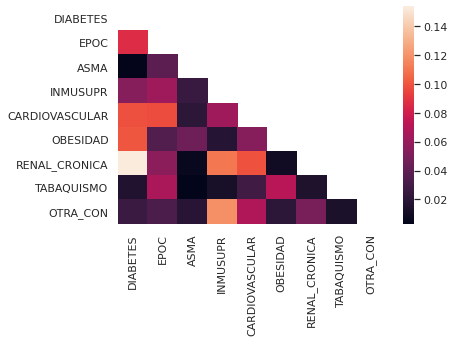

In [ ]:
predictores = general[cond_list]
corr_heatmap(predictores)

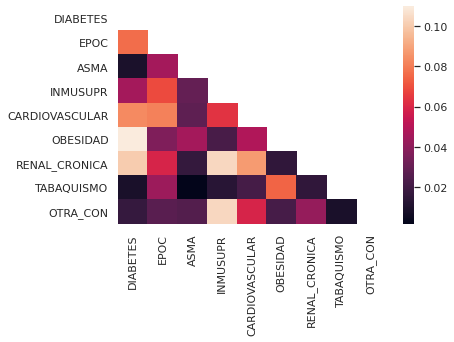

In [ ]:
pred_hosp = general[['TIPO_PACIENTE']+ cond_list]
p_hosp = filter_drop(pred_hosp, 'TIPO_PACIENTE', 'HOSPITALIZADO')
corr_heatmap(p_hosp)

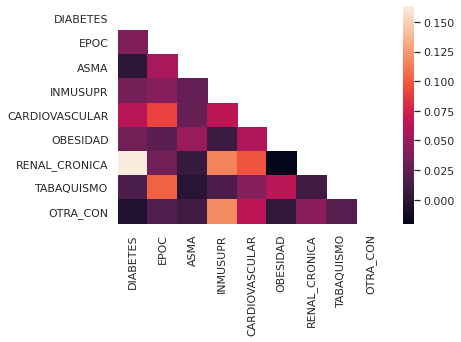

In [ ]:
pred_muerto = general[['ESTADO']+cond_list]
p_muerto = filter_drop(pred_muerto, 'ESTADO', 'MUERTO')
corr_heatmap(p_muerto)

In [ ]:
sit_pacientes = ['SECTOR', 'SEXO',  'EDAD', 'ENTIDAD_UM', 
                 'ENTIDAD_RES', 'FECHA_INGRESO', 
                 'FECHA_SINTOMAS','FECHA_DEF', 
                 'INTUBADO', 'NACIONALIDAD', 'UCI', 'GRUPO', 'ESTADO']
sit_df = general[sit_pacientes]
sit_df = sit_df.assign(DIA = lambda x:
                x.FECHA_INGRESO - x.FECHA_INGRESO.min())
sit_df.DIA = sit_df.DIA.dt.days
sit_df.head()

,SECTOR,SEXO,EDAD,ENTIDAD_UM,ENTIDAD_RES,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NACIONALIDAD,UCI,GRUPO,ESTADO,DIA
0,IMSS,HOMBRE,27,TABASCO,TABASCO,2020-05-04,2020-05-02,NaT,97,EXTRANJERA,97,ADULTO 20s,VIVO,112
1,IMSS-BIENESTAR,HOMBRE,24,JALISCO,JALISCO,2020-03-19,2020-03-17,NaT,97,EXTRANJERA,97,ADULTO 20s,VIVO,66
2,IMSS-BIENESTAR,MUJER,54,BAJA CALIFORNIA,BAJA CALIFORNIA,2020-04-06,2020-04-01,NaT,2,EXTRANJERA,2,ADULTO 50s,VIVO,84
3,IMSS-BIENESTAR,HOMBRE,30,CIUDAD DE MÉXICO,CIUDAD DE MÉXICO,2020-04-17,2020-04-10,NaT,2,EXTRANJERA,2,ADULTO 20s,VIVO,95
4,IMSS-BIENESTAR,MUJER,60,SINALOA,SINALOA,2020-04-13,2020-04-13,2020-04-22,2,EXTRANJERA,2,ADULTO 50s,MUERTO,91


[]

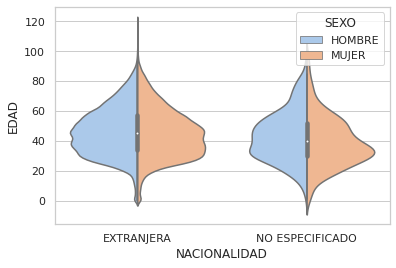

In [ ]:
sns.violinplot(x = 'NACIONALIDAD', y = 'EDAD', 
               hue = 'SEXO', split = True, data = sit_df)
plt.plot()

In [ ]:
estado_diarios = sit_df.groupby(['ENTIDAD_UM', 'FECHA_INGRESO'])\
[['FECHA_INGRESO', 'UCI', 'INTUBADO']].count()
estado_diarios.columns =['INGRESADOS', 'UCI', 'INTUBADOS']
estado_diarios = estado_diarios.reset_index()

top_casos = estado_diarios\
.groupby(['ENTIDAD_UM']).sum()\
.sort_values('INGRESADOS',ascending = False ).tail(10).index.values.tolist()


In [ ]:
casos_junio = estado_diarios[
    estado_diarios['FECHA_INGRESO']>= '2020-06-01']

In [ ]:
estado_dias = sit_df.groupby(['ENTIDAD_UM', 'DIA'])\
[['DIA', 'UCI', 'INTUBADO']].count()
estado_dias.columns = ['INGRESADOS', 'UCI', 'INTUBADOS']
estado_dias = estado_dias.reset_index()
estado_dias = estado_dias[estado_dias['ENTIDAD_UM'].isin(top_casos)]
dias_recientes = estado_dias[estado_dias['DIA']>140]

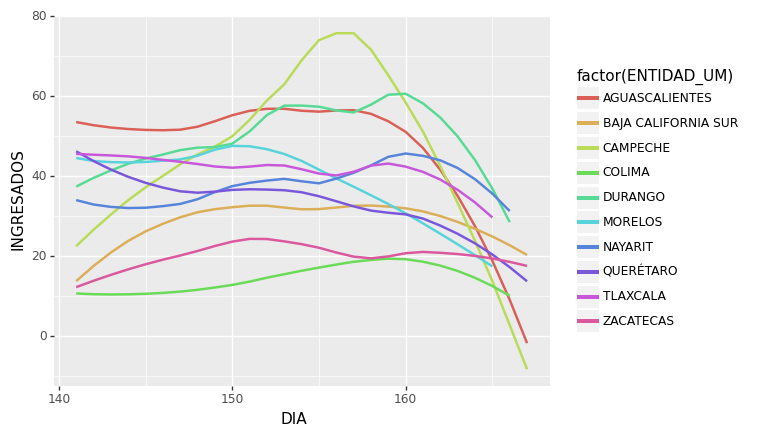

<ggplot: (8759661190783)>

In [ ]:
#!pip install scikit-misc
from plotnine import ggplot, geom_smooth, geom_line, geom_point, aes, stat_smooth, facet_wrap

(ggplot(dias_recientes[dias_recientes['ENTIDAD_UM'].isin(top_casos)], 
        aes(x = 'DIA', y = 'INGRESADOS',
            color ='factor(ENTIDAD_UM)')) 
+ geom_smooth(method = 'loess', se = False)
)#+ geom_line(alpha= 0.5))

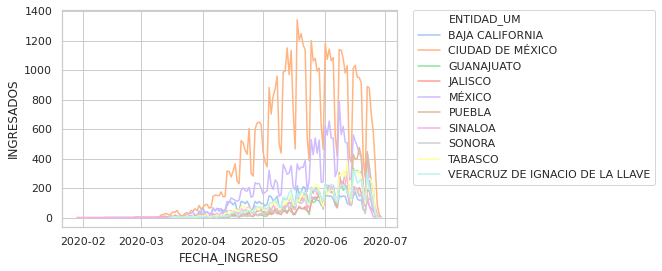

In [ ]:
sns.lineplot(x = 'FECHA_INGRESO', y = 'INGRESADOS', hue = 'ENTIDAD_UM',
             data = estado_diarios[estado_diarios.ENTIDAD_UM.isin(top_casos)])
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad=0.)
plt.show()